## Busqueda semantica

Realizar un sistema de recuperación basado en la base de datos vectorial (VDB). 

## Importar librerias

In [44]:
from pinecone import Pinecone
import pandas as pd
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
import time

## configurar variables de ambiente y rutas

In [45]:
load_dotenv()
OPENAI_ENDPOINT = os.environ["AZURE_OPENAI_ENDPOINT"]
OPENAI_API_KEY = os.environ["AZURE_OPENAI_API_KEY"] 
EMBEDDING_DEPLOYMENT = os.environ["AZURE_EMBEDDING_DEPLOYMENT"] 
OPENAI_API_VERSION =os.environ["OPENAI_API_VERSION"] 

api_key = os.environ.get('PINECONE_API_KEY')
environment = os.environ.get('PINECONE_ENVIRONMENT')
use_serverless = os.environ.get("USE_SERVERLESS", "False").lower() == "true"

## consulta de textos/documentos en VDB

### crear cliente para conexion con modelo de embedding de azure openIA

In [47]:
client = AzureOpenAI(
  api_key = OPENAI_API_KEY,  
  api_version = OPENAI_API_VERSION,
  azure_endpoint = OPENAI_ENDPOINT
)
def generar_embedding(texto:str, modelo:str=EMBEDDING_DEPLOYMENT)->list[float]:
    """Funcion para crear embedings a partir de un texto usando modelo model """
    return client.embeddings.create(input = [texto], model=modelo).data[0].embedding

### conexion con base de datos vectorial

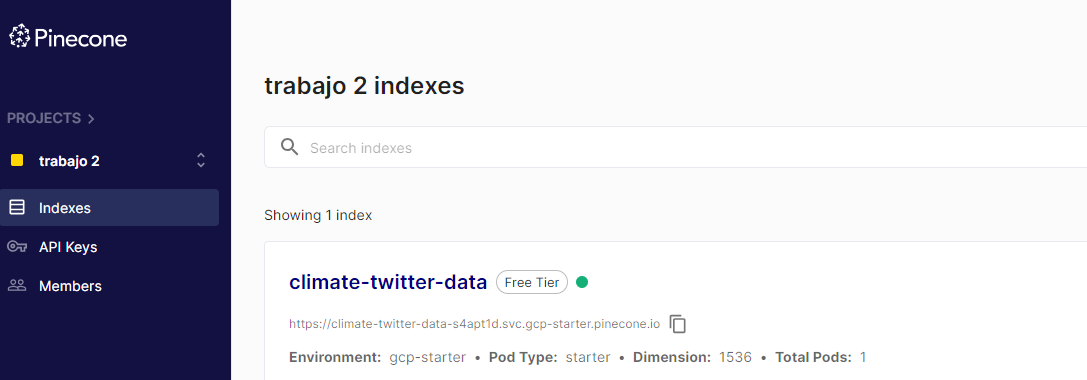

In [48]:
# configure client
pc = Pinecone(api_key=api_key)

### conexion a indice de VDB creado previamente

In [49]:
for nombre_indice in pc.list_indexes().names():
    print(nombre_indice)

nombre_indice = 'climate-twitter-data'  
# connect to index
index = pc.Index(nombre_indice)
time.sleep(1)
# view index stats
index.describe_index_stats()

climate-twitter-data


{'dimension': 1536,
 'index_fullness': 0.61254,
 'namespaces': {'': {'vector_count': 61254}},
 'total_vector_count': 61254}

### Consultas(queries):  

Vamos a realizar consultas de *tweets similares*, primero crear embedding con el texto del la consulta y buscar los n tweets similares.

In [50]:
def busqueda_documentos(query: str, indice: Pinecone.Index,numero_docu:int = 5):
    # crear vector del quey
    xq = generar_embedding(query, modelo=EMBEDDING_DEPLOYMENT)

    # Conusltar indice
    respuesta = indice.query(vector=xq, top_k=numero_docu, include_metadata=True)
    return respuesta


In [51]:
query = "Future of Humanity"
resultado = busqueda_documentos(query, indice= index,numero_docu=10)
resultado


{'matches': [{'id': '44223',
              'metadata': {'date': '2019-09-27',
                           'hashtags': '#sustainability #environment',
                           'location': 'Mumbai, India',
                           'search_hashtags': '#environment',
                           'sentiment1': '',
                           'texto': 'humanity has entered a period of '
                                    'extraordinary transformation.. a must '
                                    'read article by chip fletcher '
                                    'https://www.civilbeat.org/2019/09/humanity-has-entered-a-period-of-extraordinary-transformation/ '
                                    '| #sustainability #environment '
                                    '@fletcher_chip |. date: 2019-09-27. '
                                    'location: mumbai, india. sentiment:'},
              'score': 0.851913393,
              'values': []},
             {'id': '45485',
              'meta

In [53]:
for result in resultado['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['texto']}")

0.85: humanity has entered a period of extraordinary transformation.. a must read article by chip fletcher https://www.civilbeat.org/2019/09/humanity-has-entered-a-period-of-extraordinary-transformation/ | #sustainability #environment @fletcher_chip |. date: 2019-09-27. location: mumbai, india. sentiment:
0.85: humanity has entered a period of extraordinary transformation.. a must read article by chip fletcher https://www.civilbeat.org/2019/09/humanity-has-entered-a-period-of-extraordinary-transformation/ | #sustainability #environment @fletcher_chip |. date: 2019-09-27. location: mumbai, india. sentiment:
0.85: humanity equals 'life sustainability' our #visionquest to help #savetheplanet &amp; fight #climatechange by saying this simple phrase, #justsayhola. become a #holacrusader. #humanity #oceans #land #air #apple #timcook #earthday2019 #earthday https://youtu.be/ak591ec72o8 via @youtube. date: 2019-04-20. location: florida, usa. sentiment:
0.85: mankind has driven thousands of spec

In [59]:
query = "Future of Humanity florida"
resultado = busqueda_documentos(query, indice= index,numero_docu=5)
resultado

{'matches': [{'id': '36286',
              'metadata': {'date': '2019-03-17',
                           'hashtags': '#Sustainability #ClimateChange',
                           'location': 'Florida, USA',
                           'search_hashtags': '#sustainability',
                           'sentiment1': '',
                           'texto': 'grim implications for the future of '
                                    'humanity. #sustainability #climatechange. '
                                    'date: 2019-03-17. location: florida, usa. '
                                    'sentiment:'},
              'score': 0.877198458,
              'values': []},
             {'id': '36620',
              'metadata': {'date': '2019-05-02',
                           'hashtags': '#savetheplanet',
                           'location': 'Florida, USA',
                           'search_hashtags': '#savetheplanet',
                           'sentiment1': '',
                           'text

In [60]:
for result in resultado['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['texto']}")

0.88: grim implications for the future of humanity. #sustainability #climatechange. date: 2019-03-17. location: florida, usa. sentiment:
0.87: people really out here talking about the future as if we have one. #savetheplanet. date: 2019-05-02. location: florida, usa. sentiment:
0.87: the only place humans have, maybe try to do better, for the future generations, for the kids #amwriting #savetheplanet #globalcitizen #green #newgreendeal #globalwarming . date: 2019-09-04. location: florida, usa. sentiment:
0.87: the only place humans have, maybe try to do better, for the future generations, for the kids #amwriting #savetheplanet #globalcitizen #green #newgreendeal #globalwarming. date: 2019-09-04. location: florida, usa. sentiment:
0.87: we are all going to die. #climatechange . date: 2019-11-24. location: florida, usa. sentiment: positive


In [62]:
query = "Future of Humanity francia"
resultado = busqueda_documentos(query, indice= index,numero_docu=5)
for result in resultado['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['texto']}")

0.87: l'avenir est notre #marchepourleclimat #fridaysforfuture #paris #streetphotography • http://www.thefilthyalley.com. date: 2019-03-17. location: paris, france. sentiment:
0.87: #climatechange #youthforclimate "civiliser la terre ? passer de l'espèce humaine à l'humanité ? mais qu'espérer d'homo sapiens demens ? comment se masquer le gigantesque et terrifiant problème des carences de l'être humain ? partout domination, exploitation, haine, mépris." morin. date: 2019-03-15. location: paris, france. sentiment:
0.87: the future is in your hands. #fridaysforfuture #ivotenature #climatestrike #eubiodiversity #euelections2019. date: 2019-05-24. location: paris, france. sentiment:
0.87: the future is in your hands. #fridaysforfuture #ivotenature #climatestrike #eubiodiversity #euelections2019. date: 2019-05-24. location: paris, france. sentiment:
0.86: #fridays4future #climatestrike siguiente paso evolutivo para evitar extinción de homo sapiens y colapso de su civilización: ¡¡¡ seguir ind